In [1]:
# planning_agent.py
import operator
from typing import Annotated, List, Sequence, TypedDict, Literal
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
import functools

from ddgs import DDGS
from datetime import datetime
import time


In [2]:
# Define the state structure
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
 

In [3]:
@tool
def search_web(query: str) -> str:
    """Search the web for information""" 
    try:
        # Retry logic to handle transient issues, know issue
        results = None
        RETRY_COUNT = 5
        for i in range(RETRY_COUNT):
            with DDGS() as ddgs:
                results = ddgs.text(query, max_results=3)
            
            if results is not None and len(results) > 0:
                break
            time.sleep(1)

        if not results:
            return "No search results found"
            
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No description')}\n"
                f"   URL: {result.get('href', 'No URL')}"
            )
        
        res = "\n\n".join(formatted_results) 
        return res
    except Exception as e:
        return f"Search error: {str(e)}"
 

In [4]:
@tool
def get_current_datetime() -> str: 
    """
    Get the current date and time.
    Returns:
        str: Current date and time in format dd-MMM-yyyy hh:mm:ss AM/PM
        Example: 02-Aug-2025 03:45:30 PM
    """
    now = datetime.now()
    formatted_datetime = now.strftime("%d-%b-%Y %I:%M:%S %p")
    return formatted_datetime

In [5]:
# Create tool node
class ToolNode:
    def __init__(self, tools: list):
        self.tools = {tool.name: tool for tool in tools}
    
    def __call__(self, state: AgentState):
        messages = state["messages"]
        last_message = messages[-1]
        
        call_stack.append(f"last_message: {last_message}")

        # Process all tool calls in the last message
        outputs = []
        for tool_call in last_message.tool_calls:
            tool = self.tools[tool_call["name"]]
            result = tool.invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=result,
                    tool_call_id=tool_call["id"]
                )
            )

        call_stack.append(f"outputs: {output}")
        
        return {"messages": outputs}

In [6]:
def create_planner_agent():

    model = ChatOllama(model="qwen3:8b",
                         temperature=0
                         #,model_kwargs={"think": True}
                         )
    
    # Define available tools
    tools = [search_web, get_current_datetime]
    
    # This creates a model that CAN call tools, but doesn't EXECUTE them yet
    model_with_tools = model.bind_tools(tools)
    
    # Create prompt for the planner
    planner_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a planning agent that creates step-by-step plans to fulfill user requests.
        
        When given a task, you should:
        1. Break it down into smaller subtasks
        2. Determine which tools are needed for each step
        3. Execute the plan in the correct order
        
        Available tools: 
        - search_web(query): Search the web for information
        - get_current_datetime(): Get current date and time in dd-MMM-yyyy hh:mm:ss AM/PM format  

        Always create a concrete plan with specific steps. Always fetch **today's date** and current time using get_current_date time tool. Use Web search to validate all the information. Think step by step."""),
        MessagesPlaceholder(variable_name="messages"),
    ])
    
    # Create the planner chain
    planner = planner_prompt | model_with_tools
    
    return planner


In [7]:

# Define node functions
def plan_node(state: AgentState):
    """Node responsible for creating and updating plans"""
    planner = create_planner_agent()
    result = planner.invoke({"messages": state["messages"]})
    return {"messages": [result]}

def execute_tools(state: AgentState):
    """Node responsible for executing tools"""
    tool_node = ToolNode([search_web, get_current_datetime])
    return tool_node(state)

def should_continue(state: AgentState) -> Literal["execute_tools", "__end__"]:
    """Determine if we should continue or end"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there are tool calls, we need to execute them
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "execute_tools"
    # Otherwise, we're done
    return "__end__"


In [8]:

# Build the graph
def create_planning_graph():
    # Create the graph
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("planner", plan_node)
    workflow.add_node("execute_tools", execute_tools)
    
    # Add edges
    workflow.add_edge("execute_tools", "planner")
    
    # Set entry point
    workflow.set_entry_point("planner")
    
    # Add conditional edges
    workflow.add_conditional_edges(
        "planner",
        should_continue,
    )
    
    return workflow

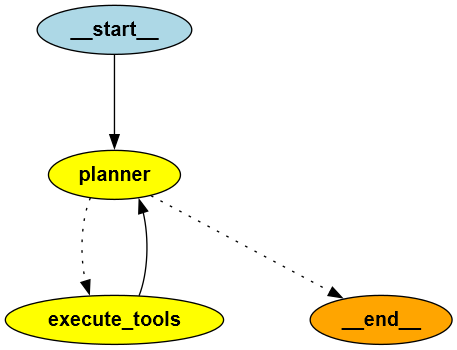

In [9]:
from IPython.display import Image, display

wf = create_planning_graph()
app = wf.compile()

display(Image(app.get_graph().draw_png()))

In [10]:
wf = create_planning_graph()
app = wf.compile()

call_stack = []
call_stack.append("Initializing call stack")

# Example query
query = "I want to plan a trip to Paris next week. Check the weather and find information about tourist attractions."

#query = "What is the population of the capital of France?"
# Run the agent
inputs = {"messages": [HumanMessage(content=query)]}

print("Planning Agent Execution:")
print("=" * 50)

# Stream the results
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        # Print the last message
        if value["messages"]:
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and last_message.content:
                print(f"  Content: {last_message.content}")
            if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                print(f"  Tool calls: {last_message.tool_calls}")
        print("-" * 30)

print("\nFinal State:")
print("=" * 50)
final_state = app.invoke(inputs)
for message in final_state["messages"]:
    if hasattr(message, 'content') and message.content:
        print(f"Message: {message.content}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print(f"Tool calls: {message.tool_calls}")

print("call_stack: ", call_stack)

Planning Agent Execution:
Node 'planner':
  Content: <think>
Okay, the user wants to plan a trip to Paris next week. They need information on the weather and tourist attractions. Let me break this down.

First, I should figure out the dates for next week. Since the current date isn't specified, I'll need to get today's date using the get_current_datetime function. Once I have today's date, I can determine the dates for next week. That's important because weather forecasts are typically for specific dates.

Next, I need to check the weather for Paris during those dates. The user mentioned next week, so I should look up the weather forecast for Paris from today's date plus seven days. Using the search_web function with a query like "Paris weather next week" or specifying the exact dates would be effective. But maybe the search should include the specific dates once I calculate them.

Then, for tourist attractions, I should find popular spots in Paris. A web search for "top tourist attrac

In [11]:
wf = create_planning_graph()
app = wf.compile()

call_stack = []
call_stack.append("Initializing call stack")

inputs = {"messages": [HumanMessage(content="Find out the highest valuation public company as today. what is the location of that company. Who is the CEO. Find out its competetor. How those two companies are differnt.")]}

print("Planning Agent Execution:")
print("=" * 50)

# Stream the results
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        # Print the last message
        if value["messages"]:
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and last_message.content:
                print(f"  Content: {last_message.content}")
            if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                print(f"  Tool calls: {last_message.tool_calls}")
        print("-" * 30)

# print("\nFinal State:")
# print("=" * 50)
# final_state = app.invoke(inputs)
# for message in final_state["messages"]:
#     if hasattr(message, 'content') and message.content:
#         print(f"Message: {message.content}")
#     if hasattr(message, 'tool_calls') and message.tool_calls:
#         print(f"Tool calls: {message.tool_calls}")

print("call_stack: ", call_stack)

Planning Agent Execution:
Node 'planner':
  Content: <think>
Okay, the user wants to find the highest valuation public company today, along with its location, CEO, a competitor, and how those two companies differ. Let me break this down step by step.

First, I need to determine the current date and time because the valuation might change daily. So I'll start by calling get_current_datetime(). That's straightforward.

Next, I need to find the highest valuation public company as of today. Since this information can change, I should use the search_web function with a query like "highest valuation public company today". This will give me the latest data. Once I get that info, I can note the company's name, location, and CEO from the search results.

Then, I need to find a competitor of that company. The search results might mention competitors, so I can look for that. Alternatively, I might need to search again with a query like "[Company Name] competitors" to get specific names. Once I ha

In [12]:
wf = create_planning_graph()
app = wf.compile()

call_stack = []
call_stack.append("Initializing call stack")


complex_query = """I'm planning a 10-day European trip for my family (4 people total: 2 adults, 2 teenagers) in late October. 
We want to visit Paris, Rome, and Barcelona. Our budget is $8000 for the entire trip.

Requirements:
1. Research the best travel dates within October
2. Check weather conditions for each city during that time
3. Find and compare flight options between cities (we prefer morning flights)
4. Look for family-friendly accommodations in central locations
5. Identify top attractions in each city suitable for teenagers
6. Check local transportation options
7. Verify that all expenses fit within our $8000 budget
8. Create a day-by-day itinerary with buffer time

We're interested in art, history, food, and some shopping. Please be thorough in your research and planning."""

inputs = {"messages": [HumanMessage(content=complex_query)]}

print("Planning Agent Execution:")
print("=" * 50)

# Stream the results
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        # Print the last message
        if value["messages"]:
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and last_message.content:
                print(f"  Content: {last_message.content}")
            if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                print(f"  Tool calls: {last_message.tool_calls}")
        print("-" * 30)

# print("\nFinal State:")
# print("=" * 50)
# final_state = app.invoke(inputs)
# for message in final_state["messages"]:
#     if hasattr(message, 'content') and message.content:
#         print(f"Message: {message.content}")
#     if hasattr(message, 'tool_calls') and message.tool_calls:
#         print(f"Tool calls: {message.tool_calls}")

print("call_stack: ", call_stack)

Planning Agent Execution:
Node 'planner':
  Content: <think>
Okay, let's tackle this user's request step by step. First, they want a 10-day European trip for their family in late October, visiting Paris, Rome, and Barcelona with a $8000 budget. Let me break down the requirements.

The first task is to research the best travel dates within October. Since they mentioned late October, maybe the end of the month? I should check if there are any major events or holidays that might affect availability or prices. Also, considering the weather, late October in Europe can vary. Paris might be cooler, Rome could be mild, and Barcelona might still have some warmth. I need to confirm the typical weather for those dates.

Next, checking the weather for each city during the proposed dates. Using a web search to find the average temperatures and conditions in late October for each city. That will help ensure comfort and plan activities accordingly.

Then, finding flight options between the cities. Th

## This is what gets sent to Ollama's REST API [model.bind_tools(tools)]
#### POST /api/chat
#### Host: localhost:11434
#### Content-Type: application/json

```JSON
{
  "model": "qwen3:4b",
  "messages": [
    {
      "role": "system",
      "content": "You are a planning agent that creates step-by-step plans to fulfill user requests.\n\nWhen given a task, you should:\n1. Break it down into smaller subtasks\n2. Determine which tools are needed for each step\n3. Execute the plan in the correct order\n\nAvailable tools:\n- get_weather(city): Get weather information for a city\n- search_web(query): Search the web for information\n- book_flight(origin, destination, date): Book a flight between cities\n\nAlways create a concrete plan with specific steps. Think step by step."
    },
    {
      "role": "user",
      "content": "I want to plan a trip to Paris next week. Check the weather and find information about tourist attractions."
    }
  ],
  "tools": [
     
    {
      "type": "function",
      "function": {
        "name": "search_web",
        "description": "Search the web for information",
        "parameters": {
          "type": "object",
          "properties": {
            "query": {
              "type": "string"
            }
          },
          "required": [
            "query"
          ]
        }
      }
    }
  ],
  "stream": false,
  "options": {
    "temperature": 0
  }
}
```